In [1]:
import lightning.pytorch as pl
import numpy as np
import torch
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers.wandb import WandbLogger

from config import Config, load_config
from datasets import get_data
from models import get_model

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [4]:
# initialize data attributes and loaders
%env BATCH_SIZE=128
%env DATASET_NAME=QPM_species
%env EMB_DIMS=128
%env MODEL_NAME=flow_spherical_mse
%env OOD=1:4

config = load_config()
config.load_data()
config.print_labels()
dm = config.datamodule
assert dm

env: BATCH_SIZE=128
env: DATASET_NAME=QPM_species
env: EMB_DIMS=128
env: MODEL_NAME=flow_spherical_mse
env: OOD=1:4


In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species
Loaded 333290 images
Dataset type val label type: species
Loaded 43293 images
Dataset type test label type: species
Loaded 43520 images
Dataset type train label type: species
Loaded 42153 images
Dataset type val label type: species
Loaded 5269 images
Dataset type test label type: species
Loaded 5270 images


In [6]:
model = config.get_model()

In [7]:
model_id = 'p965yk91'

In [8]:
from pathlib import Path
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robust_ml/model-{model_id}:best")
model = model.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
predict_loader = dm.predict_dataloader()

In [15]:
from models.common import edl_probs
from tqdm.auto import tqdm

ind_labels = []
ind_u_norms = []
ind_v_norms = []

ood_labels = []
ood_u_norms = []
ood_v_norms = []

rnd_u_norms = []
rnd_v_norms = []

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    ind_u_norms.extend(u_norm.detach().cpu().numpy())
    ind_v_norms.extend(v_norm.detach().cpu().numpy())
    ind_labels.extend(y.cpu().numpy())
print("test InD - OK")

# predict set (ood)
for batch_idx, batch in enumerate(tqdm(predict_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    ood_u_norms.extend(u_norm.detach().cpu().numpy())
    ood_v_norms.extend(v_norm.detach().cpu().numpy())
    ood_labels.extend(y.cpu().numpy())
print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    rnd_u_norms.extend(u_norm.detach().cpu().numpy())
    rnd_v_norms.extend(v_norm.detach().cpu().numpy())
print("test RnD - OK")

ind_labels = np.array(ind_labels).squeeze()
ind_u_norms = np.array(ind_u_norms).squeeze()
ind_v_norms = np.array(ind_v_norms).squeeze()

ood_labels = np.array(ood_labels).squeeze()
ood_u_norms = np.array(ood_u_norms).squeeze()
ood_v_norms = np.array(ood_v_norms).squeeze()

rnd_u_norms = np.array(rnd_u_norms).squeeze()
rnd_v_norms = np.array(rnd_v_norms).squeeze()

print(ind_labels.shape, ind_u_norms.shape, ind_v_norms.shape)
print(ood_labels.shape, ood_u_norms.shape, ood_v_norms.shape)
print(rnd_u_norms.shape, rnd_v_norms.shape)

100%|██████████| 340/340 [00:12<00:00, 27.97it/s]


test InD - OK


100%|██████████| 412/412 [00:14<00:00, 28.12it/s]


test OoD - OK


100%|██████████| 100/100 [00:03<00:00, 31.98it/s]


test RnD - OK
(43520,) (43520,) (43520,)
(52692,) (52692,) (52692,)
(12800,) (12800,)


In [19]:
print(ind_u_norms.mean(), ind_u_norms.std())
print(ind_v_norms.mean(), ind_v_norms.std())

print(ood_u_norms.mean(), ood_u_norms.std())
print(ood_v_norms.mean(), ood_v_norms.std())

print(rnd_u_norms.mean(), rnd_u_norms.std())
print(rnd_v_norms.mean(), rnd_v_norms.std())

0.9998633 0.00076914235
0.0069441334 0.001870747
1.0000377 0.00066979555
0.0061674835 0.010107634
2.5224824 0.2592354
12.469126 0.32990876


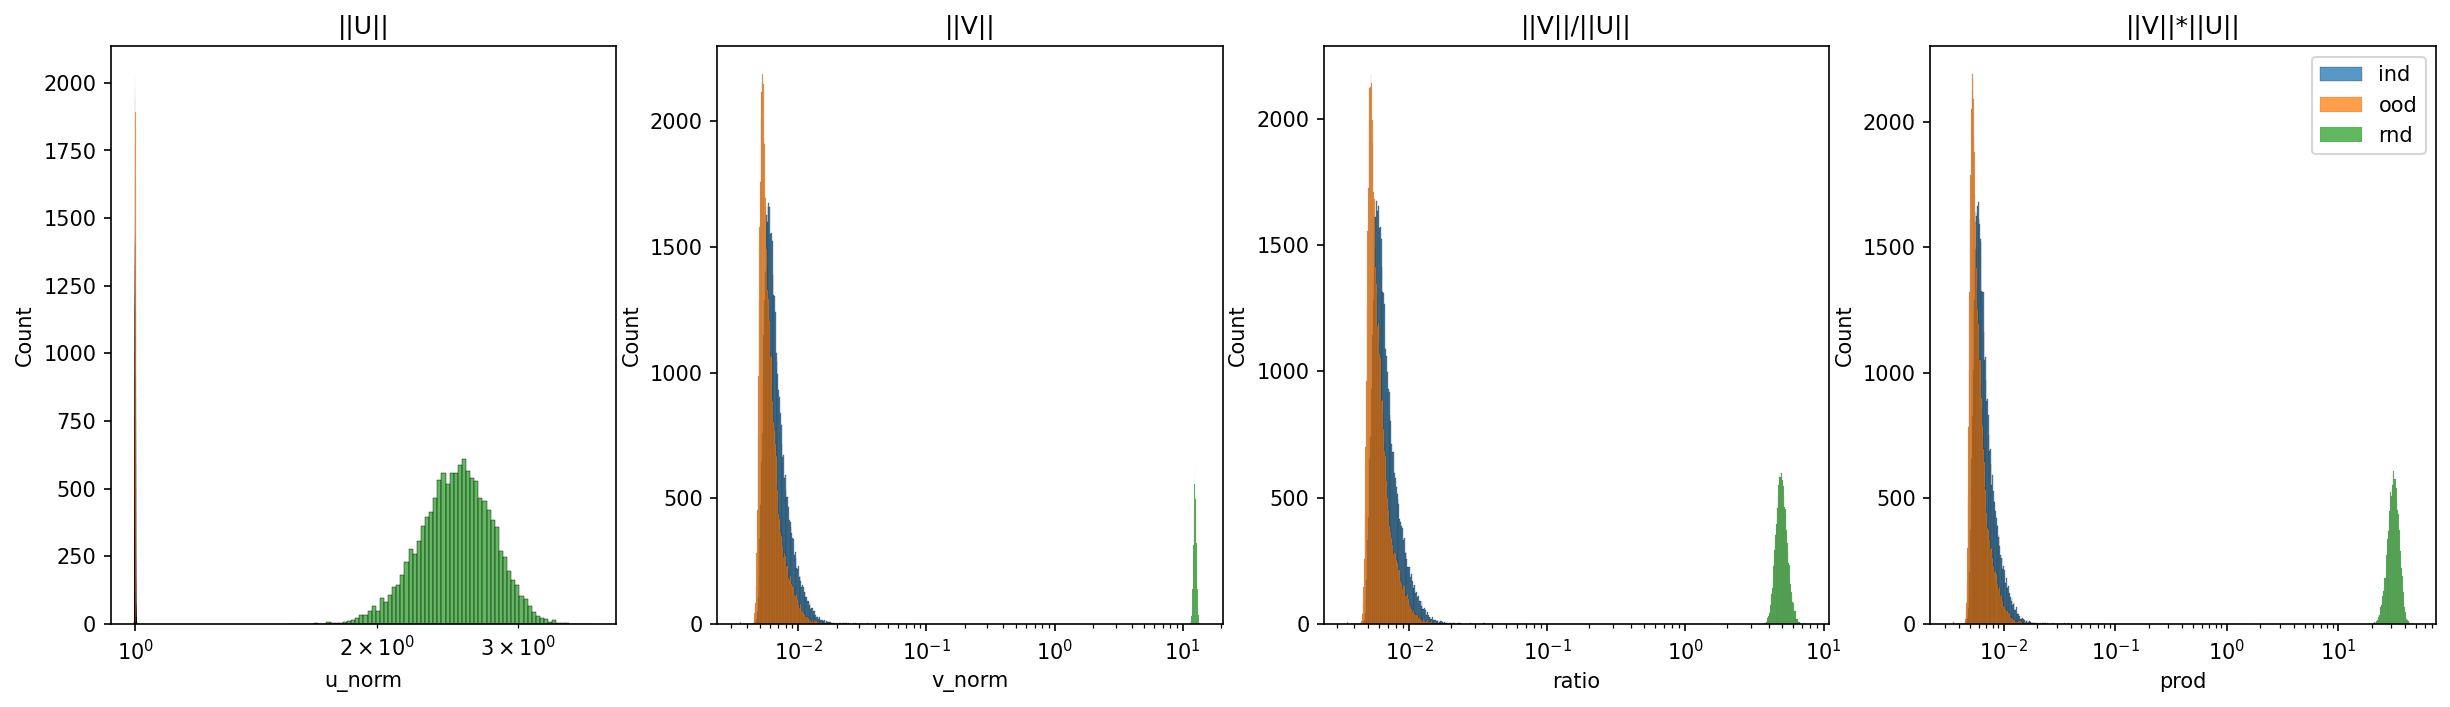

In [21]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['figure.dpi'] = 150

data_ind = pd.DataFrame(dict(label=ind_labels, u_norm=ind_u_norms, v_norm=ind_v_norms, ratio=ind_v_norms/ind_u_norms, prod=ind_v_norms*ind_u_norms))
data_ood = pd.DataFrame(dict(label=ood_labels, u_norm=ood_u_norms, v_norm=ood_v_norms, ratio=ood_v_norms/ood_u_norms, prod=ood_v_norms*ood_u_norms))
data_rnd = pd.DataFrame(dict(u_norm=rnd_u_norms, v_norm=rnd_v_norms, ratio=rnd_v_norms/rnd_u_norms, prod=rnd_v_norms*rnd_u_norms))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 5))

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    sns.histplot(data=data_ind, x="u_norm", log_scale=True, fill=True, label='ind', ax=ax1)
    sns.histplot(data=data_ood, x="u_norm", log_scale=True, fill=True, label='ood', ax=ax1)
    sns.histplot(data=data_rnd, x="u_norm", log_scale=True, fill=True, label='rnd', ax=ax1)

    sns.histplot(data=data_ind, x="v_norm", log_scale=True, fill=True, label='ind', ax=ax2)
    sns.histplot(data=data_ood, x="v_norm", log_scale=True, fill=True, label='ood', ax=ax2)
    sns.histplot(data=data_rnd, x="v_norm", log_scale=True, fill=True, label='rnd', ax=ax2)

    sns.histplot(data=data_ind, x="ratio", log_scale=True, fill=True, label='ind', ax=ax3)
    sns.histplot(data=data_ood, x="ratio", log_scale=True, fill=True, label='ood', ax=ax3)
    sns.histplot(data=data_rnd, x="ratio", log_scale=True, fill=True, label='rnd', ax=ax3)

    sns.histplot(data=data_ind, x="prod", log_scale=True, fill=True, label='ind', ax=ax4)
    sns.histplot(data=data_ood, x="prod", log_scale=True, fill=True, label='ood', ax=ax4)
    sns.histplot(data=data_rnd, x="prod", log_scale=True, fill=True, label='rnd', ax=ax4)

ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.legend()
plt.savefig(f"assets/figures/qpm_species_flow_mse_M128_ood_u_{config.ood[0]}.png")

In [43]:
df = pd.concat([data_ind, data_ood], axis=0)
print(df['label'].unique())

[0 1 2 3 4]


In [65]:
N = 64

groupwise = {}

for i in range(5):
    df_slice = df[df['label'] == i]
    d = df_slice.rolling(N).agg(['mean', 'std'])
    d = d.iloc[N-1::N, :]
    groupwise[i] = d.copy()
    

for i in range(5):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 5))

    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        sns.histplot(data=data_ind, x="u_norm", log_scale=True, fill=True, label='ind', ax=ax1)
        sns.histplot(data=data_ood, x="u_norm", log_scale=True, fill=True, label='ood', ax=ax1)
        sns.histplot(data=data_rnd, x="u_norm", log_scale=True, fill=True, label='rnd', ax=ax1)

        sns.histplot(data=data_ind, x="v_norm", log_scale=True, fill=True, label='ind', ax=ax2)
        sns.histplot(data=data_ood, x="v_norm", log_scale=True, fill=True, label='ood', ax=ax2)
        sns.histplot(data=data_rnd, x="v_norm", log_scale=True, fill=True, label='rnd', ax=ax2)

        sns.histplot(data=data_ind, x="ratio", log_scale=True, fill=True, label='ind', ax=ax3)
        sns.histplot(data=data_ood, x="ratio", log_scale=True, fill=True, label='ood', ax=ax3)
        sns.histplot(data=data_rnd, x="ratio", log_scale=True, fill=True, label='rnd', ax=ax3)

        sns.histplot(data=data_ind, x="prod", log_scale=True, fill=True, label='ind', ax=ax4)
        sns.histplot(data=data_ood, x="prod", log_scale=True, fill=True, label='ood', ax=ax4)
        sns.histplot(data=data_rnd, x="prod", log_scale=True, fill=True, label='rnd', ax=ax4)

    ax1.title.set_text('||U||')
    ax2.title.set_text('||V||')
    ax3.title.set_text('||V||/||U||')
    ax4.title.set_text('||V||*||U||')

    plt.legend()
    plt.savefig(f"assets/figures/qpm_species_flow_mse_M128_ood_u_{config.ood[0]}_groupwise.png")

           mean       std
63     0.999566  0.000701
127    0.999539  0.000683
191    0.999552  0.000714
255    0.999731  0.000703
319    0.999514  0.000675
...         ...       ...
43219  0.999718  0.000588
43283  0.999778  0.000554
43347  0.999676  0.000546
43411  0.999752  0.000462
43475  0.999513  0.000665

[229 rows x 2 columns]
